In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:30,  3.82it/s]


Epoch 1 of 100
Generator loss: 0.01371147, Discriminator loss: 0.00683790


118it [00:30,  3.84it/s]


Epoch 2 of 100
Generator loss: 0.02555441, Discriminator loss: 0.00269594


118it [00:30,  3.85it/s]


Epoch 3 of 100
Generator loss: 0.00361697, Discriminator loss: 0.01208326


118it [00:30,  3.83it/s]


Epoch 4 of 100
Generator loss: 0.01360546, Discriminator loss: 0.00689863


118it [00:30,  3.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


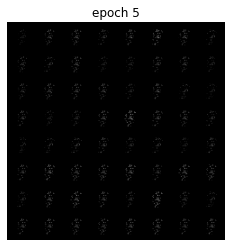

Epoch 5 of 100
Generator loss: 0.01543330, Discriminator loss: 0.00742068


118it [00:30,  3.81it/s]


Epoch 6 of 100
Generator loss: 0.02525427, Discriminator loss: 0.00289990


118it [00:31,  3.80it/s]


Epoch 7 of 100
Generator loss: 0.00590350, Discriminator loss: 0.01045060


118it [00:30,  3.82it/s]


Epoch 8 of 100
Generator loss: 0.01618781, Discriminator loss: 0.00380893


118it [00:31,  3.80it/s]


Epoch 9 of 100
Generator loss: 0.00556947, Discriminator loss: 0.00923490


118it [00:30,  3.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


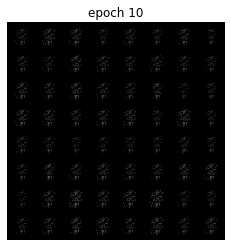

Epoch 10 of 100
Generator loss: 0.00531578, Discriminator loss: 0.00815700


118it [00:30,  3.81it/s]


Epoch 11 of 100
Generator loss: 0.02071237, Discriminator loss: 0.00363394


118it [00:31,  3.79it/s]


Epoch 12 of 100
Generator loss: 0.00832812, Discriminator loss: 0.00723881


118it [00:31,  3.80it/s]


Epoch 13 of 100
Generator loss: 0.00471213, Discriminator loss: 0.01138712


118it [00:30,  3.81it/s]


Epoch 14 of 100
Generator loss: 0.00548875, Discriminator loss: 0.00826731


118it [00:31,  3.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


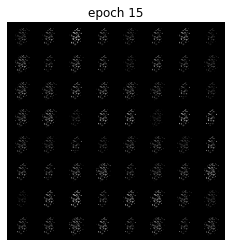

Epoch 15 of 100
Generator loss: 0.00868275, Discriminator loss: 0.00594580


118it [00:31,  3.80it/s]


Epoch 16 of 100
Generator loss: 0.04288401, Discriminator loss: 0.00469797


118it [00:30,  3.81it/s]


Epoch 17 of 100
Generator loss: 0.02227641, Discriminator loss: 0.00418016


118it [00:31,  3.80it/s]


Epoch 18 of 100
Generator loss: 0.01281303, Discriminator loss: 0.00853763


118it [00:31,  3.78it/s]


Epoch 19 of 100
Generator loss: 0.02251542, Discriminator loss: 0.00473554


118it [00:31,  3.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


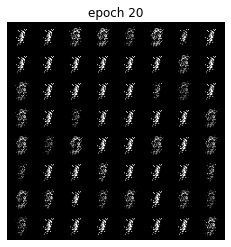

Epoch 20 of 100
Generator loss: 0.03250564, Discriminator loss: 0.00286484


118it [00:30,  3.81it/s]


Epoch 21 of 100
Generator loss: 0.02096312, Discriminator loss: 0.00398998


118it [00:30,  3.81it/s]


Epoch 22 of 100
Generator loss: 0.02811482, Discriminator loss: 0.00300140


118it [00:30,  3.83it/s]


Epoch 23 of 100
Generator loss: 0.05610146, Discriminator loss: 0.00296448


118it [00:30,  3.83it/s]


Epoch 24 of 100
Generator loss: 0.03904628, Discriminator loss: 0.00446274


118it [00:31,  3.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


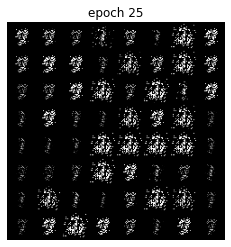

Epoch 25 of 100
Generator loss: 0.03537606, Discriminator loss: 0.00348602


118it [00:31,  3.75it/s]


Epoch 26 of 100
Generator loss: 0.03392861, Discriminator loss: 0.00274937


118it [00:31,  3.76it/s]


Epoch 27 of 100
Generator loss: 0.04262464, Discriminator loss: 0.00271074


118it [00:31,  3.75it/s]


Epoch 28 of 100
Generator loss: 0.02809718, Discriminator loss: 0.00246617


118it [00:31,  3.75it/s]


Epoch 29 of 100
Generator loss: 0.04557931, Discriminator loss: 0.00241767


118it [00:31,  3.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


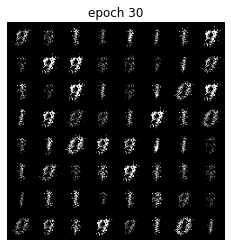

Epoch 30 of 100
Generator loss: 0.02931250, Discriminator loss: 0.00169857


118it [00:31,  3.77it/s]


Epoch 31 of 100
Generator loss: 0.02919494, Discriminator loss: 0.00265651


118it [00:31,  3.76it/s]


Epoch 32 of 100
Generator loss: 0.02763751, Discriminator loss: 0.00226475


118it [00:31,  3.78it/s]


Epoch 33 of 100
Generator loss: 0.02873994, Discriminator loss: 0.00286911


118it [00:31,  3.80it/s]


Epoch 34 of 100
Generator loss: 0.01981708, Discriminator loss: 0.00305619


118it [00:31,  3.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


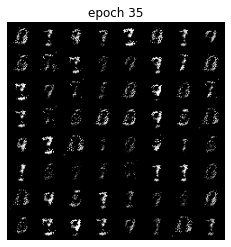

Epoch 35 of 100
Generator loss: 0.02395815, Discriminator loss: 0.00362563


118it [00:31,  3.76it/s]


Epoch 36 of 100
Generator loss: 0.01895863, Discriminator loss: 0.00425093


118it [00:31,  3.80it/s]


Epoch 37 of 100
Generator loss: 0.01559286, Discriminator loss: 0.00544006


118it [00:31,  3.78it/s]


Epoch 38 of 100
Generator loss: 0.02140573, Discriminator loss: 0.00271910


118it [00:31,  3.76it/s]


Epoch 39 of 100
Generator loss: 0.02171161, Discriminator loss: 0.00402022


118it [00:31,  3.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


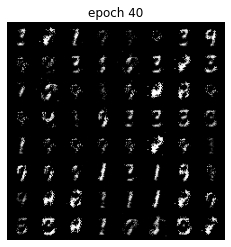

Epoch 40 of 100
Generator loss: 0.02360515, Discriminator loss: 0.00300036


118it [00:31,  3.78it/s]


Epoch 41 of 100
Generator loss: 0.01927222, Discriminator loss: 0.00420539


118it [00:31,  3.76it/s]


Epoch 42 of 100
Generator loss: 0.01391009, Discriminator loss: 0.00350374


118it [00:31,  3.78it/s]


Epoch 43 of 100
Generator loss: 0.01590551, Discriminator loss: 0.00307751


118it [00:31,  3.76it/s]


Epoch 44 of 100
Generator loss: 0.01814795, Discriminator loss: 0.00376063


118it [00:31,  3.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


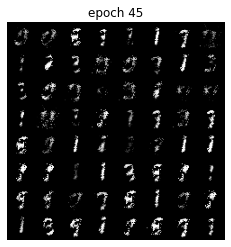

Epoch 45 of 100
Generator loss: 0.01813544, Discriminator loss: 0.00450778


118it [00:31,  3.76it/s]


Epoch 46 of 100
Generator loss: 0.01580920, Discriminator loss: 0.00417985


118it [00:31,  3.78it/s]


Epoch 47 of 100
Generator loss: 0.01350711, Discriminator loss: 0.00691165


118it [00:31,  3.75it/s]


Epoch 48 of 100
Generator loss: 0.02039650, Discriminator loss: 0.00289176


118it [00:31,  3.75it/s]


Epoch 49 of 100
Generator loss: 0.01988567, Discriminator loss: 0.00410902


118it [00:31,  3.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


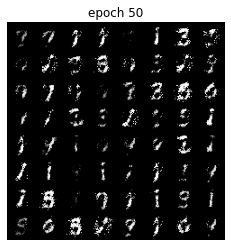

Epoch 50 of 100
Generator loss: 0.01921438, Discriminator loss: 0.00385358


118it [00:31,  3.75it/s]


Epoch 51 of 100
Generator loss: 0.01434081, Discriminator loss: 0.00474799


118it [00:31,  3.74it/s]


Epoch 52 of 100
Generator loss: 0.01947402, Discriminator loss: 0.00336489


118it [00:31,  3.74it/s]


Epoch 53 of 100
Generator loss: 0.01718487, Discriminator loss: 0.00309680


118it [00:31,  3.74it/s]


Epoch 54 of 100
Generator loss: 0.01976101, Discriminator loss: 0.00371575


118it [00:31,  3.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


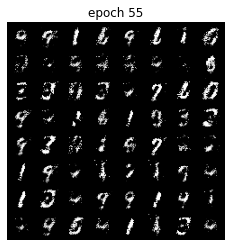

Epoch 55 of 100
Generator loss: 0.01992594, Discriminator loss: 0.00408874


118it [00:31,  3.76it/s]


Epoch 56 of 100
Generator loss: 0.01785314, Discriminator loss: 0.00425646


118it [00:31,  3.77it/s]


Epoch 57 of 100
Generator loss: 0.01559037, Discriminator loss: 0.00442703


118it [00:31,  3.75it/s]


Epoch 58 of 100
Generator loss: 0.01740247, Discriminator loss: 0.00437664


118it [00:31,  3.75it/s]


Epoch 59 of 100
Generator loss: 0.01869095, Discriminator loss: 0.00511531


118it [00:31,  3.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


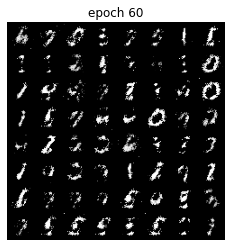

Epoch 60 of 100
Generator loss: 0.01767122, Discriminator loss: 0.00427916


118it [00:31,  3.75it/s]


Epoch 61 of 100
Generator loss: 0.01456933, Discriminator loss: 0.00534876


118it [00:31,  3.75it/s]


Epoch 62 of 100
Generator loss: 0.01339258, Discriminator loss: 0.00388880


118it [00:31,  3.74it/s]


Epoch 63 of 100
Generator loss: 0.01365322, Discriminator loss: 0.00498543


118it [00:31,  3.74it/s]


Epoch 64 of 100
Generator loss: 0.02390048, Discriminator loss: 0.00491839


118it [00:31,  3.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


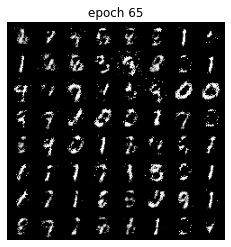

Epoch 65 of 100
Generator loss: 0.02105123, Discriminator loss: 0.00419542


118it [00:31,  3.76it/s]


Epoch 66 of 100
Generator loss: 0.01378476, Discriminator loss: 0.00453791


118it [00:31,  3.76it/s]


Epoch 67 of 100
Generator loss: 0.01658620, Discriminator loss: 0.00352054


118it [00:31,  3.75it/s]


Epoch 68 of 100
Generator loss: 0.01955572, Discriminator loss: 0.00306623


118it [00:31,  3.75it/s]


Epoch 69 of 100
Generator loss: 0.01554999, Discriminator loss: 0.00403196


118it [00:31,  3.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


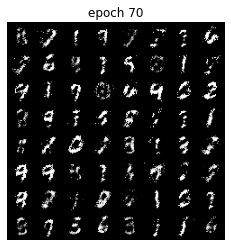

Epoch 70 of 100
Generator loss: 0.01309767, Discriminator loss: 0.00486357


118it [00:31,  3.72it/s]


Epoch 71 of 100
Generator loss: 0.01781148, Discriminator loss: 0.00338056


118it [00:31,  3.75it/s]


Epoch 72 of 100
Generator loss: 0.01896365, Discriminator loss: 0.00408933


118it [00:31,  3.76it/s]


Epoch 73 of 100
Generator loss: 0.02089709, Discriminator loss: 0.00359880


118it [00:31,  3.74it/s]


Epoch 74 of 100
Generator loss: 0.01717878, Discriminator loss: 0.00412813


118it [00:31,  3.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


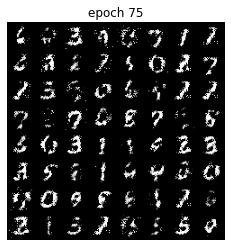

Epoch 75 of 100
Generator loss: 0.01423368, Discriminator loss: 0.00457964


118it [00:31,  3.70it/s]


Epoch 76 of 100
Generator loss: 0.01683467, Discriminator loss: 0.00461885


118it [00:31,  3.70it/s]


Epoch 77 of 100
Generator loss: 0.02309921, Discriminator loss: 0.00363988


118it [00:32,  3.68it/s]


Epoch 78 of 100
Generator loss: 0.01850516, Discriminator loss: 0.00373183


118it [00:31,  3.70it/s]


Epoch 79 of 100
Generator loss: 0.01711518, Discriminator loss: 0.00419104


118it [00:31,  3.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


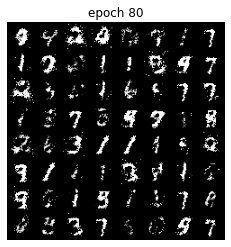

Epoch 80 of 100
Generator loss: 0.02200731, Discriminator loss: 0.00301481


118it [00:31,  3.74it/s]


Epoch 81 of 100
Generator loss: 0.01718369, Discriminator loss: 0.00485773


118it [00:31,  3.72it/s]


Epoch 82 of 100
Generator loss: 0.02635357, Discriminator loss: 0.00390528


118it [00:31,  3.73it/s]


Epoch 83 of 100
Generator loss: 0.02800706, Discriminator loss: 0.00259139


118it [00:31,  3.71it/s]


Epoch 84 of 100
Generator loss: 0.01735920, Discriminator loss: 0.00410872


118it [00:31,  3.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


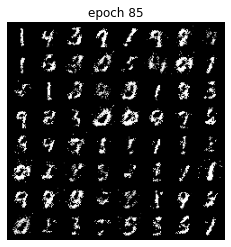

Epoch 85 of 100
Generator loss: 0.02078871, Discriminator loss: 0.00522757


118it [00:31,  3.70it/s]


Epoch 86 of 100
Generator loss: 0.02806494, Discriminator loss: 0.00342964


118it [00:31,  3.69it/s]


Epoch 87 of 100
Generator loss: 0.01873900, Discriminator loss: 0.00471688


118it [00:31,  3.70it/s]


Epoch 88 of 100
Generator loss: 0.01850043, Discriminator loss: 0.00542360


118it [00:31,  3.79it/s]


Epoch 89 of 100
Generator loss: 0.01815441, Discriminator loss: 0.00369382


118it [00:31,  3.80it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


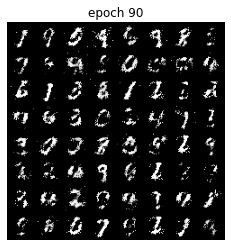

Epoch 90 of 100
Generator loss: 0.02439560, Discriminator loss: 0.00327095


118it [00:31,  3.74it/s]


Epoch 91 of 100
Generator loss: 0.02273279, Discriminator loss: 0.00380192


118it [00:32,  3.68it/s]


Epoch 92 of 100
Generator loss: 0.02122300, Discriminator loss: 0.00362054


118it [00:32,  3.66it/s]


Epoch 93 of 100
Generator loss: 0.01895481, Discriminator loss: 0.00336711


118it [00:32,  3.66it/s]


Epoch 94 of 100
Generator loss: 0.01819240, Discriminator loss: 0.00466824


118it [00:32,  3.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


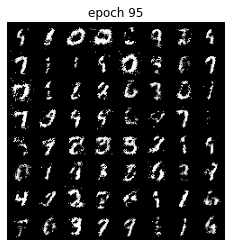

Epoch 95 of 100
Generator loss: 0.01683731, Discriminator loss: 0.00402757


118it [00:31,  3.69it/s]


Epoch 96 of 100
Generator loss: 0.02258658, Discriminator loss: 0.00566920


118it [00:32,  3.66it/s]


Epoch 97 of 100
Generator loss: 0.01720430, Discriminator loss: 0.00420679


118it [00:32,  3.67it/s]


Epoch 98 of 100
Generator loss: 0.01359797, Discriminator loss: 0.00506809


118it [00:32,  3.67it/s]


Epoch 99 of 100
Generator loss: 0.01382237, Discriminator loss: 0.00656265


118it [00:32,  3.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


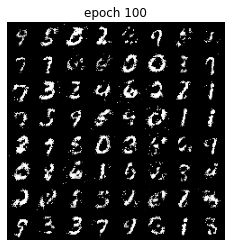

Epoch 100 of 100
Generator loss: 0.01983183, Discriminator loss: 0.00438351


In [ ]:
torch.manual_seed(7777)

def generator_loss(output, true_labels):
    ############ YOUR CODE HERE ##########

    loss_g = (1/sample_size) * (torch.sum(torch.log(output)))

    return -loss_g

    
    ######################################
    
def discriminator_loss(output, true_labels):
    ############ YOUR CODE HERE ##########
    
    loss_d = ((1/batch_size)*(torch.sum(torch.log(true_labels)))) + ((1/sample_size) * (torch.sum(torch.log(1-output))))
    
    return -loss_d
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, (data,labels) in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        
        gen_imgs = generator(noise)
        output = discriminator(gen_imgs)
        true_labels = discriminator(data)

        optim_d.zero_grad()
        loss_d = discriminator_loss(output , true_labels)
        loss_d.backward()
        optim_d.step()
        

        gen_imgs = generator(noise)
        output = discriminator(gen_imgs)
        optim_g.zero_grad()
        loss_g = generator_loss(output , true_labels)
        loss_g.backward()
        optim_g.step()
 
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

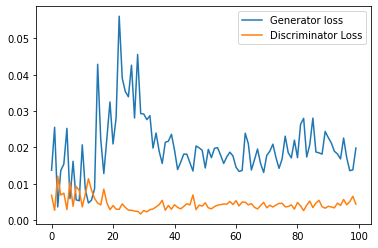

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')